In [1]:
import json
import os
import pandas as pd

In [2]:
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/LWL & EF Tobii Data Export"

In [3]:
os.chdir(data_dir)

In [66]:
tdf= pd.read_csv('Baby Toolbox_Data_Export_06_02_2021.tsv', sep='\t') 

C:\Users\tsb7592\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28,34,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [67]:
tdf.shape

(305387, 380)

In [68]:
keep = [col for col in tdf.columns if 'AOI' in col]
keep = [col for col in keep if 'Calib' not in col]

In [69]:
k24 = keep[4:76]

In [70]:
print(k24)

['AOI[LeftStim_Shoulder]Hit', 'AOI[RightStim_Hose]Hit', 'AOI[WholeScreen]Hit.4', 'AOI[LeftStim_Ladder]Hit', 'AOI[RightStim_Melon]Hit', 'AOI[WholeScreen]Hit.5', 'AOI[LeftStim_Rooster]Hit', 'AOI[RightStim_Playground]Hit', 'AOI[WholeScreen]Hit.6', 'AOI[LeftStim_Bike]Hit', 'AOI[RightStim_Sneaker]Hit', 'AOI[WholeScreen]Hit.7', 'AOI[LeftStim]Hit', 'AOI[RightStim]Hit', 'AOI[WholeScreen]Hit.8', 'AOI[LeftStim]Hit.1', 'AOI[RightStim]Hit.1', 'AOI[WholeScreen]Hit.9', 'AOI[LeftStim]Hit.2', 'AOI[RightStim]Hit.2', 'AOI[WholeScreen]Hit.10', 'AOI[LeftStim]Hit.3', 'AOI[RightStim]Hit.3', 'AOI[WholeScreen]Hit.11', 'AOI[LeftStim]Hit.4', 'AOI[RightStim]Hit.4', 'AOI[WholeScreen]Hit.12', 'AOI[LeftStim]Hit.5', 'AOI[RightStim]Hit.5', 'AOI[WholeScreen]Hit.13', 'AOI[LeftStim]Hit.6', 'AOI[RightStim]Hit.6', 'AOI[WholeScreen]Hit.14', 'AOI[LeftStim]Hit.7', 'AOI[RightStim]Hit.7', 'AOI[WholeScreen]Hit.15', 'AOI[LeftStim]Hit.8', 'AOI[RightStim]Hit.8', 'AOI[WholeScreen]Hit.16', 'AOI[LeftStim]Hit.9', 'AOI[RightStim]Hit.9'

In [71]:
tdf=tdf[k24]

In [72]:
tdata = round(tdf.mean(),4).to_dict()

In [73]:
left =[]
right=[]
away =[]
onscreen = []
i = 0
for val in tdata:
    if i%3 == 0:
        rv = tdata[val]
        left.append(tdata[val])
    elif i%3 == 1:
        rv += tdata[val]
        right.append(tdata[val])
    else:
        rv = 1 - rv
        away.append(rv)
        onscreen.append(tdata[val])
    i+=1

In [74]:
k24[3:6]

['AOI[LeftStim_Ladder]Hit', 'AOI[RightStim_Melon]Hit', 'AOI[WholeScreen]Hit.5']

# json file

In [4]:
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/Tobii Verbose Files/Claire"

In [5]:
os.chdir(data_dir)

In [ ]:
#newfile ='949BCA6A-D3D6-426C-9A94-E806F84E4E72@845BDD10-B9AF-4592-AA4E-0CCE76A0E8CD@00025@2021-05-11-22.21.08.674@ExecutiveFunction@Claire@VerboseGazeData.json'

In [ ]:
#df=pd.read_json(newfile)

In [6]:
df=pd.read_json('949BCA6A-D3D6-426C-9A94-E806F84E4E72@845BDD10-B9AF-4592-AA4E-0CCE76A0E8CD@00024@2021-05-11-22.11.48.356@LookListening@Claire@VerboseGazeData.json')

In [10]:
cols=['itemID','eventName','gazeLocationName', 'gazeLocationOnScreen',"lookAtPointX", "lookAtPointY"]

In [11]:
df=df[cols]

In [ ]:
#Finding the index for presentLiveItem and completeLiveItem to subset the pieces we need for analysis
begin =list(df[df['eventName'].str.contains('presentedLiveItem')].index)
end = list(df[df['eventName'].str.contains('completedLiveItem')].index)

In [13]:
len(df.gazeLocationOnScreen.value_counts())

2

In [ ]:
expected = pd.DataFrame(
    {'Left': left,
     'Right': right,
     'Away': away,'Onscreen':onscreen
    })
expected

In [ ]:
len(end)

# Fisher Exact Test 

In [ ]:
#tsv file
exp = pd.DataFrame(columns=('left', 'right','onScreenAway','offScreenAway'))
for i in range(24):
    lcol,rcol,wcol = k24[3*i:3*i+3]
    
    subset = tdf[tdf[wcol].notnull()]
    
    a=subset[lcol].sum()
    b=subset[rcol].sum()
    d=subset[(subset[lcol]==0) & (subset[rcol]==0) &(subset[wcol]==1)].shape[0]
    e=subset[(subset[lcol]==0) & (subset[rcol]==0) &(subset[wcol]==0)].shape[0]

    exp.loc[i] = [a, b ,d, e]

In [ ]:
#json file
obs = pd.DataFrame(columns=('L', 'R','onScreenAway','offScreenAway'))
items =[]
for i in range(len(end)):
    sub = df.iloc[begin[i]+1:end[i]]
    items.extend(sub.itemID.dropna().unique())
    a, b, c = sub.gazeLocationName.value_counts()[['left','right','away']].round(4) 
    if len(sub[sub['gazeLocationName'] == 'away'].gazeLocationOnScreen.value_counts()) == 2:
        d,e = sub[sub['gazeLocationName'] == 'away'].gazeLocationOnScreen.value_counts()
    else:
        d = c
        e = 0
    obs.loc[i] = [a, b ,d, e]

In [53]:
exp = pd.read_csv('C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/count.csv')

In [54]:
exp =exp.iloc[:,:4]

In [55]:
l1 =newobs.to_numpy()
l2= exp.to_numpy()

In [56]:
l2

array([[541., 341.,  95.,  65.],
       [176., 761.,   0.,  23.],
       [497., 314.,  20., 130.],
       [793., 129.,  48.,  71.],
       [357., 435.,  40., 128.],
       [471., 201., 151., 218.],
       [274., 594.,  91.,  81.],
       [600., 230.,  14., 117.],
       [353., 489.,  29.,  89.],
       [538., 198.,  11., 214.],
       [176., 824.,   0.,  41.],
       [381., 440.,  40., 180.],
       [681., 318.,  14.,  28.],
       [308., 483., 139., 110.],
       [706., 244.,  62.,  29.],
       [837.,  63.,   7.,  53.],
       [645., 289.,   0.,  28.],
       [673., 329.,  17.,  21.],
       [768., 194.,  26.,  52.],
       [461., 364.,   6., 130.],
       [543., 475.,   0.,  22.],
       [285., 619.,  56.,  80.],
       [336., 330.,  29., 265.],
       [725.,  70.,  27., 140.]])

In [61]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

for i in range(24):
    data = [l1[i], l2[2]]
    
    stat, p, dof, expected = chi2_contingency(data)
    print(items[i])
    
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('')

Shoulder_Hose_G5
probability=0.950, critical=7.815, stat=282.107
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Ladder_Melon_G5
probability=0.950, critical=7.815, stat=493.841
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Rooster_Playground_G5
probability=0.950, critical=7.815, stat=433.739
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Tricycle_Sneaker_G5
probability=0.950, critical=7.815, stat=549.188
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Hose_Shoulder_G5
probability=0.950, critical=7.815, stat=224.375
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Melon_Ladder_G5
probability=0.950, critical=7.815, stat=301.661
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Playground_Rooster_G5
probability=0.950, critical=7.815, stat=298.962
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)

Sneaker_Tricycle_G5
pro

In [ ]:
from scipy.stats import chisquare
chisq = pd.DataFrame(columns=('items', 'stat','p'))
for i in range(24):
    ob = obs.iloc[i]
    ex = expected.iloc[i]
    stat, pv = chisquare(f_obs=ob, f_exp=ex)
    chisq.loc[i] = [items[i], round(stat,3) ,round(pv,3)]


In [ ]:
chisq.to_csv('C:/Users/TEMP/Box/Baby Toolbox Operations/Analysis/chisquare.csv', index=False)

# Rewrite Lookalgorithm

In [1]:
import json
import os
import pandas as pd

In [2]:
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/Tobii Verbose Files/Claire"

In [3]:
os.chdir(data_dir)

In [4]:
df=pd.read_json('949BCA6A-D3D6-426C-9A94-E806F84E4E72@845BDD10-B9AF-4592-AA4E-0CCE76A0E8CD@00024@2021-05-11-22.11.48.356@LookListening@Claire@VerboseGazeData.json')

In [5]:
cols=['itemID','eventName','gazeLocationName', 'gazeLocationOnScreen',"lookAtPointX", "lookAtPointY"]

In [6]:
df.columns

Index(['calibrationPoint1AverageX', 'calibrationPoint1AverageY',
       'calibrationPoint2AverageX', 'calibrationPoint2AverageY',
       'calibrationPoint3AverageX', 'calibrationPoint3AverageY',
       'calibrationPoint4AverageX', 'calibrationPoint4AverageY', 'elapsedTime',
       'eventName', 'gazeEngineState', 'gazeLocationPercentX',
       'gazeLocationPercentY', 'itemID', 'dataKey', 'dataValue',
       'arEulerAngleFaceX', 'arEulerAngleFaceY', 'arEulerAngleFaceZ',
       'arFaceAnchorTransformRow0Column0', 'arFaceAnchorTransformRow0Column1',
       'arFaceAnchorTransformRow0Column2', 'arFaceAnchorTransformRow0Column3',
       'arFaceAnchorTransformRow1Column0', 'arFaceAnchorTransformRow1Column1',
       'arFaceAnchorTransformRow1Column2', 'arFaceAnchorTransformRow1Column3',
       'arFaceAnchorTransformRow2Column0', 'arFaceAnchorTransformRow2Column1',
       'arFaceAnchorTransformRow2Column2', 'arFaceAnchorTransformRow2Column3',
       'arFaceAnchorTransformRow3Column0', 'arFaceAnc

In [7]:
df.head()

,calibrationPoint1AverageX,calibrationPoint1AverageY,calibrationPoint2AverageX,calibrationPoint2AverageY,calibrationPoint3AverageX,calibrationPoint3AverageY,calibrationPoint4AverageX,calibrationPoint4AverageY,elapsedTime,eventName,...,lookAtPointX,lookAtPointY,calibrationFocalPoint,mediaCenterPointPercentX,mediaCenterPointPercentY,cameraImageFilename,gazeLocationName,gazeLocationOnScreen,gazeLocationZoneSet,includePriorGazeLocationPoints
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,beganCalibration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000588,data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000630,data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000662,data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000689,data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
import math
import numpy as np

def lookAlgorithm(df, usevals, searchTime=1.0167, margX=10, margY=15, alignX=30, alignY=30):
    '''
    Input: 
        df: the json file read to a pandas dataframe
        usevals: a string of the column name
    Output:
         results in a pandas dataframe
    '''
    
    if 'lookAtPoint' in usevals:
        useX = "lookAtPointX"
        useY = "lookAtPointY"
    elif 'arHitTestLookAtPointPosition' in usevals:
        useX = "arHitTestLookAtPointPositionX"
        useY = "arHitTestLookAtPointPositionY"
    
    startRows =list(df[df['eventName'].str.contains('presentedCalibrationItem')].index)
    endRows =list(df[df['eventName'].str.contains('completedCalibrationItem')].index)
    
    if len(startRows) != len(endRows):
        print("Early-terminated Calibration")
        return
    
    RMs=[]
    for i in range(len(startRows)):
        rollingMeans = pd.DataFrame(columns=('Cali','calibFocal', 'rowIndex','rollingX','rollingY','props')) 
        sub = df.iloc[startRows[i]:endRows[i]+1]
        firstCheck_time = df.iloc[startRows[i]]['elapsedTime'] + searchTime
        firstCheck_row = sub[sub['elapsedTime'] <= firstCheck_time].index.max()
       
        for j in range(firstCheck_row, endRows[i]+1):
            rollingMeans.loc[j] = [i,'tmp', j, -9999,-9999, -9999]
            
            useData =sub[(sub['elapsedTime'] >= df.iloc[j]['elapsedTime'] - searchTime) & (sub['elapsedTime'] <= df.iloc[j]['elapsedTime'])&(sub['elapsedTime'] >= df.iloc[startRows[i]]['elapsedTime'])]
            useData = useData[~useData.eventName.str.contains('complet')]
                              
            rollingMeans.loc[j]['calibFocal']=useData['calibrationFocalPoint'].unique()[0]
            rollingMeans.loc[j]['rollingX']=round(useData[useX].mean(),2)
            rollingMeans.loc[j]['rollingY']=round(useData[useY].mean(),2)
            rollingMeans.loc[j]['props']=round(100*(useData[(useData[useX] >= useData[useX].mean()- margX) & (useData[useX] <= useData[useX].mean()+ margX) & (useData[useY] >= useData[useY].mean()- margY) & (useData[useY] <= useData[useY].mean()+ margY)]).shape[0]/useData[useData[useY].notnull()].shape[0],2)
          
        RMs.append(rollingMeans)
         
    RMs = pd.concat(RMs, ignore_index=True)
    
    use=[]
    for i in range(4):
        ur = RMs[(RMs['props'] >= 80) & (RMs['Cali']==i)].head(1)
        use.append(ur)
    useRows = pd.concat(use)
    useRows = useRows.reset_index()
    
    #if useRows.shape[0]>4:
    useRows['calibrationSet'] =(useRows.index + 1)/4
    useRows['calibrationSet'] =useRows['calibrationSet'].apply(np.ceil)
        
    tr = useRows[useRows['calibFocal']=='topRight']['rollingX'].values[0]
    br = useRows[useRows['calibFocal']=='bottomRight']['rollingX'].values[0]
    tl = useRows[useRows['calibFocal']=='topLeft']['rollingX'].values[0]
    bl = useRows[useRows['calibFocal']=='bottomLeft']['rollingX'].values[0]    
    
    #save the 4 screenSide numbers to a dictionary 
    screenSide={}
    if abs(tr- br) <= alignX:
        screenSide['rightSide'] = max(tr, br)
    else:
        screenSide['rightSide'] = np.NaN
    
    if abs(tl- bl) <= alignX:
        screenSide['leftSide']= min(tl, bl)
    else:
        screenSide['leftSide']= np.NaN
    
    tr = useRows[useRows['calibFocal']=='topRight']['rollingY'].values[0]
    br = useRows[useRows['calibFocal']=='bottomRight']['rollingY'].values[0]
    tl = useRows[useRows['calibFocal']=='topLeft']['rollingY'].values[0]
    bl = useRows[useRows['calibFocal']=='bottomLeft']['rollingY'].values[0]
    
    if abs(tr- tl) <= alignY:
        screenSide['topSide'] = round((tr+tl)/2,2)
    else:
        screenSide['topSide'] = np.NaN
        
    if abs(br- bl) <= alignY:
        screenSide['bottomSide']= round((br+bl)/2,2)
    else:
        screenSide['bottomSide']= np.NaN   
        
    if useRows['calibFocal'].isnull().any():
        screenSide['rightSide'] = np.NaN
        screenSide['leftSide'] = np.NaN
        screenSide['topSide'] = np.NaN
        screenSide['bottomSide'] = np.NaN
 
    return RMs,useRows,screenSide

In [9]:
RM, lookDetected, ss=lookAlgorithm(df,'lookAtPoint')

In [10]:
RM

,Cali,calibFocal,rowIndex,rollingX,rollingY,props
0,0,topLeft,89,32.1,10.86,35.48
1,0,topLeft,90,31.78,10.76,33.87
2,0,topLeft,91,31.61,10.48,35.0
3,0,topLeft,92,31.4,10.57,32.79
4,0,topLeft,93,31.07,10.51,32.79
...,...,...,...,...,...,...
275,3,topRight,594,114.78,0.84,100.0
276,3,topRight,595,114.66,0.66,100.0
277,3,topRight,596,114.57,0.46,100.0
278,3,topRight,597,114.47,0.39,100.0


In [11]:
lookDetected

,index,Cali,calibFocal,rowIndex,rollingX,rollingY,props,calibrationSet
0,17,0,topLeft,106,25.33,9.66,83.33,1.0
1,100,1,bottomRight,266,113.45,14.3,85.25,1.0
2,167,2,bottomLeft,409,42.37,18.47,83.61,1.0
3,237,3,topRight,556,111.09,6.09,86.67,1.0


In [12]:
ss

{'rightSide': 113.45, 'leftSide': 25.33, 'topSide': 7.88, 'bottomSide': 16.38}

In [13]:
def Modify_screenSide(ss, leftright= 25, topbottom=50, ratio= 0.4):
    '''
    Input: 
        ss: dictionary contains the four screensides
        leftright: the margin to modify the left/right side
        topbottom: the margin to modify the top/bottom side
        ratio: the ratio to identify left and right side
        
    Output:
         screenSide: the modified dictionary contains new four screensides
    '''
    
    screenSide =ss.copy()
    screenSide['rightSide'] += leftright
    screenSide['leftSide'] -= leftright
    screenSide['topSide'] -= topbottom
    screenSide['bottomSide'] += topbottom
    
    leftM = (screenSide['rightSide']-screenSide['leftSide'])*ratio
    rightM = (screenSide['rightSide']-screenSide['leftSide'])*(1-ratio)
    print(leftM, rightM)
    
    return screenSide, leftM, rightM

In [14]:
def Location(row):
    if row['lookAtPointX'] > ss['leftSide'] and row['lookAtPointX'] <leftM  and row['lookAtPointY']>ss['topSide']and row['lookAtPointY']<ss['bottomSide'] :
        return 'left'
    elif row['lookAtPointX'] > rightM  and row['lookAtPointX'] <ss['rightSide'] and row['lookAtPointY']>ss['topSide']and row['lookAtPointY']<ss['bottomSide']:
        return 'right'
    else:
        return 'away'

In [15]:
def OnScreen(row):
    if row['lookAtPointX'] >leftM and row['lookAtPointX']< rightM and row['lookAtPointY']<ss['bottomSide']and row['lookAtPointY']>ss['topSide'] :
        return 'true'
    else:
        return 'false'

In [16]:
ss, leftM, rightM=Modify_screenSide(ss)
ss

55.248000000000005 82.872


{'rightSide': 138.45,
 'leftSide': 0.3299999999999983,
 'topSide': -42.12,
 'bottomSide': 66.38}

In [58]:
#json file

def ReProcess(df, ss, leftM, rightM):
    '''
    Input: 
        df: the json file read to a pandas dataframe
        ss: the modified dictionary contains new four screensides
        leftM(float): the left margin
        rightM(float): the right margin
        
    Output:
         new: the pandas dataframe contains the new count 
    '''
    #Finding the index for presentLiveItem and completeLiveItem to subset the pieces we need for analysis
    begin =list(df[df['eventName'].str.contains('presentedLiveItem')].index)
    end = list(df[df['eventName'].str.contains('completedLiveItem')].index)
    df['NewLocation'] = df.apply( lambda row : Location(row), axis = 1)
    df['NewOnScreen'] = df.apply( lambda row : OnScreen(row), axis = 1)

    new = pd.DataFrame(columns=('L', 'R','onScreenAway','offScreenAway'))
    items =[]
    for i in range(len(end)):
        sub = df.iloc[begin[i]+1:end[i]]
        items.extend(sub.itemID.dropna().unique())
        #sub = sub[['gazeLocationName', 'gazeLocationOnScreen','lookAtPointX','lookAtPointY']].dropna()
        a, b, c = sub.NewLocation.value_counts()[['left','right','away']].round(4) 
        if len(sub[sub['NewLocation'] == 'away'].NewOnScreen.value_counts()) == 2:
            d,e = sub[sub['NewLocation'] == 'away'].NewOnScreen.value_counts()
        else:
            d = c
            e = 0
        new.loc[i] = [a, b ,d, e]
        
    return new, items

In [59]:
newobs, items =ReProcess(df, ss, leftM, rightM)

In [60]:
newobs

,L,R,onScreenAway,offScreenAway
0,280,62,160,129
1,108,277,228,4
2,200,159,257,9
3,240,48,303,29
4,186,248,146,46
5,260,113,204,46
6,118,307,143,54
7,235,145,233,8
8,145,240,213,31
9,271,141,198,14


In [20]:
newobs.to_csv('C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/json_count.csv', index=False)

In [84]:
leftM

55.248000000000005

In [103]:
test.head()

,gazeLocationName,gazeLocationOnScreen,lookAtPointX,lookAtPointY,NewLocation,NewOnScreen
18140,left,true,47.572538,43.869741,left,true
18142,left,true,47.782235,43.375868,left,true
18143,left,true,47.929164,43.065842,left,true
18144,left,true,48.953816,44.536013,left,true
18145,left,true,51.134527,52.561805,left,true


In [104]:
test.tail()

,gazeLocationName,gazeLocationOnScreen,lookAtPointX,lookAtPointY,NewLocation,NewOnScreen
18711,away,false,57.141669,93.066797,away,false
18713,away,false,97.622260,106.235847,away,false
18714,away,false,122.532777,120.194435,away,false
18715,away,false,167.774871,148.304015,away,false
18716,away,false,238.047093,175.236925,away,false


In [32]:
ss

{'rightSide': 138.45,
 'leftSide': 0.3299999999999983,
 'topSide': -42.12,
 'bottomSide': 66.38}

(0.0, 150.0)

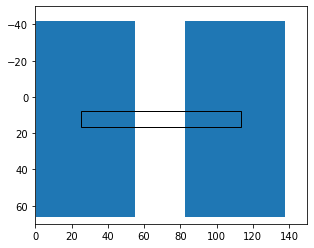

In [40]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
#{'rightSide': 113.45, 'leftSide': 25.33, 'topSide': 7.88, 'bottomSide': 16.38}

width = 113.45- 25.33
height = 16.38 - 7.88

w1= 55.248-0.329
h1= 66.38+42.12

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')

ax1.add_patch(
    patches.Rectangle((0.329, -42.12), w1, h1))
ax1.add_patch(
    patches.Rectangle(( 82.872, -42.12), w1, h1))
ax1.add_patch(
    patches.Rectangle((25.33, 7.88), width, height, fill=False))

plt.ylim((70,-50))
plt.xlim((0,150))